In [ ]:
# pip install mido pretty_midi  tensorflow keras

In [12]:
import os
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd


from keras.models import load_model
from music21 import instrument, note, chord, midi


2024-07-12 05:33:40.183177: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#function to load midi files from a folder, because of the nesting of the folders  add a root file walk so as to go through the directory 
def load_midi_files(directory):
    midi_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.mid'):
                file_path = os.path.join(root, file)
                try:
                    midi_files.append(pretty_midi.PrettyMIDI(file_path))
                except:
                    print(f"Could not parse {file_path}")
    return midi_files



midi_files = load_midi_files('/Users/nabilomondi/Downloads/Final Project IRONHACK/MIDI FILE/lmd_matched/F/F/A')

In [4]:
#function to exttract the notes in a midi file so asto have data points to work with 
def extract_notes(midi):
    notes = []
    for instrument in midi.instruments:
        if not instrument.is_drum:
            for note in instrument.notes:
                notes.append((note.start, note.end, note.pitch, note.velocity))
    return notes

In [5]:
#loop thought the midi from extracted midi files to get the notes data before normalising with minmax scaler
all_notes = []
for midi in midi_files:
    all_notes.extend(extract_notes(midi))
if not all_notes:
    raise ValueError("No valid notes found in the MIDI files.")

In [ ]:
def check_midi_files(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.mid'):
                file_path = os.path.join(root, file)
                try:
                    midi_data = pretty_midi.PrettyMIDI(file_path)
                    print(f"Checking file: {file_path}")
                    
                    # Basic information
                    print(f"  Duration: {midi_data.get_end_time()} seconds")
                    print(f"  Instruments: {len(midi_data.instruments)}")
                    
                    # Check instruments and notes
                    for i, instrument in enumerate(midi_data.instruments):
                        if not instrument.is_drum:
                            print(f"  Instrument {i}: {pretty_midi.program_to_instrument_name(instrument.program)}")
                            print(f"    Notes: {len(instrument.notes)}")
                            
                           
                            for note in instrument.notes[:5]:  # Print first 5 notes
                                print(f"      Note - start: {note.start}, end: {note.end}, pitch: {note.pitch}, velocity: {note.velocity}")
                        
                except Exception as e:
                    print(f"Could not parse {file_path}: {e}")

In [ ]:
#check_midi_files(r"C:\Users\kaise\Downloads\midi files\lmd_matched\A\A")

In [6]:
#get start times, end times, pitches and velocities for the notes
start_times = [note[0] for note in all_notes]
end_times = [note[1] for note in all_notes]
pitches = [note[2] for note in all_notes]
velocities = [note[3] for note in all_notes]

In [7]:
#scale the data  from above step
scaler = MinMaxScaler()
start_times = scaler.fit_transform(np.array(start_times).reshape(-1, 1)).flatten()
end_times = scaler.transform(np.array(end_times).reshape(-1, 1)).flatten()
pitches = scaler.fit_transform(np.array(pitches).reshape(-1, 1)).flatten()
velocities = scaler.fit_transform(np.array(velocities).reshape(-1, 1)).flatten()

In [8]:
normalized_notes = np.stack([start_times, end_times, pitches, velocities], axis=1)

In [9]:
normalized_notes

array([[0.00801021, 0.00972668, 0.55882353, 0.97413793],
       [0.01029884, 0.01201531, 0.55882353, 0.97413793],
       [0.01258747, 0.01430394, 0.66176471, 0.97413793],
       ...,
       [0.79260383, 0.79384573, 0.80882353, 0.54310345],
       [0.79384573, 0.79508762, 0.77941176, 0.54310345],
       [0.79508762, 0.80173692, 0.80882353, 0.54310345]])

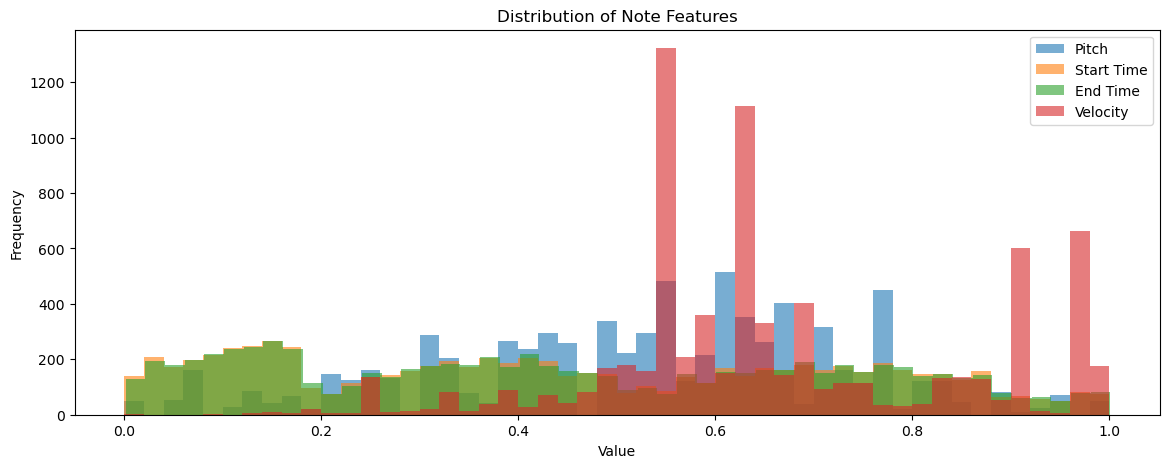

In [10]:
plt.figure(figsize=(14, 5))
plt.hist(pitches, bins=50, alpha=0.6, label='Pitch')
plt.hist(start_times, bins=50, alpha=0.6, label='Start Time')
plt.hist(end_times, bins=50, alpha=0.6, label='End Time')
plt.hist(velocities, bins=50, alpha=0.6, label='Velocity')
plt.legend(loc='upper right')
plt.title('Distribution of Note Features')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [11]:
sequence_length = 100

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

X, y = create_sequences(normalized_notes, sequence_length)

In [ ]:
# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Dropout

# model = Sequential()
# model.add(LSTM(256, input_shape=(sequence_length, 4), return_sequences=True))
# model.add(Dropout(0.3))
# model.add(LSTM(256))
# model.add(Dense(4))

# model.compile(loss='mean_squared_error', optimizer='adam')
# model.summary()

In [ ]:
# model.fit(X, y, epochs=10, batch_size=1000, validation_split=0.2)

In [13]:
model = load_model('/Users/nabilomondi/Documents/Finalproject/my_model.h5')

In [14]:
## method one is seed generation based on the seed sequence in the last sample works not good

# def generate_music(model, seed_sequence, length):
#     generated = []
#     current_sequence = seed_sequence
#     for _ in range(length):
#         predicted = model.predict(current_sequence.reshape(1, sequence_length, 4))[0]
#         generated.append(predicted)
#         current_sequence = np.vstack([current_sequence[1:], predicted])
#     return generated

# # Using the last sequence in the training data as the seed sequence
# seed_sequence = X[-2]
# generated_music = generate_music(model, seed_sequence, 500)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━

In [44]:
"""
method 2 using probabilites to make predicitons based on the sample brought in (error on null values likely due to number instability)
# Logarithmic approach (using epsilon and temprature to base predictions epsilon to prevent null values from low numbers)
import logging

# Configure logging
logging.basicConfig(level=logging.DEBUG)  # Set the logging level as desired

def generate_music(model, seed_sequence, length, int_to_note, temperature=1.0):
    generated = []
    current_sequence = seed_sequence
    for _ in range(length):
        prediction = model.predict(current_sequence.reshape(1, len(current_sequence), 4))[0]

        logging.debug(f"Raw prediction: {prediction}")

        # Apply temperature sampling with epsilon to prevent NaN
        epsilon = 1e-9
        prediction = np.log(prediction + epsilon) / temperature
        exp_preds = np.exp(prediction)
        
        # Normalize to ensure probabilities sum up to 1
        prediction = exp_preds / np.sum(exp_preds)

        logging.debug(f"Normalized prediction: {prediction}")

        # Check for NaN values in prediction
        if np.isnan(np.sum(prediction)):
            raise ValueError("NaN values encountered in prediction probabilities.")

        # Sample from the distribution
        next_index = np.random.choice(len(prediction), p=prediction)
        next_note = int_to_note[next_index]

        generated.append(next_note)
        next_note_array = np.zeros((1, 4))
        next_note_array[0, 0] = next_index
        current_sequence = np.vstack([current_sequence[1:], next_note_array])

    return generated

# Example usage assuming int_to_note is defined correctly
try:
    generated_notes = generate_music(model, seed_sequence, length=500, int_to_note=int_to_note, temperature=0.8)
    # Further processing or saving to MIDI
except ValueError as ve:
    print(f"ValueError: {ve}")
    # Handle the error gracefully (e.g., log, retry, etc.)"""


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━

/var/folders/7v/1k3tf50152b3pjvsxtnpb34w0000gp/T/ipykernel_8625/3325548833.py:17: RuntimeWarning: invalid value encountered in log
  prediction = np.log(prediction + epsilon) / temperature


In [ ]:


def generate_music(model, seed_sequence, length, int_to_note, temperature=1.0):
    generated = []
    current_sequence = seed_sequence
    for _ in range(length):
        prediction = model.predict(current_sequence.reshape(1, len(current_sequence), 4))[0]

        # Apply temperature scaling to adjust the softmax output
        scaled_prediction = np.power(prediction, 1.0 / temperature)
        scaled_prediction = scaled_prediction / np.sum(scaled_prediction)

        # Sample from the distribution
        next_index = np.random.choice(len(prediction), p=scaled_prediction)
        next_note = int_to_note[next_index]

        generated.append(next_note)
        next_note_array = np.zeros((1, 4))
        next_note_array[0, 0] = next_index
        current_sequence = np.vstack([current_sequence[1:], next_note_array])

    return generated


In [36]:
def create_midi(generated_notes, output_file='generated_music.mid'):
    offset = 0
    output_notes = []

    for pattern in generated_notes:
        # Handle chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        else:
            # Handle single note
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        offset += 0.5

    midi_stream = midi.stream.Stream(output_notes)
    midi_stream.write('midi', fp=output_file)

In [32]:
def int_to_note_mapping(predictions, int_to_note):
    return [int_to_note[np.argmax(prediction)] for prediction in predictions]

In [33]:
notes = all_notes
pitchnames = sorted(set(item for item in notes))
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

In [37]:
generated_notes = generate_music(model, seed_sequence, length=500, int_to_note=int_to_note, temperature=0.8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━

/var/folders/7v/1k3tf50152b3pjvsxtnpb34w0000gp/T/ipykernel_8625/2972103053.py:11: RuntimeWarning: invalid value encountered in log
  prediction = np.log(prediction + epsilon) / temperature


ValueError: NaN values encountered in prediction probabilities.

In [ ]:
def save_to_midi(generated_notes, output_file):
    midi = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)

    for note in generated_notes:
        start, end, pitch, velocity = scaler.inverse_transform(note.reshape(1, -1))[0]
        note = pretty_midi.Note(
            velocity=int(velocity),
            pitch=int(pitch),
            start=start,
            end=end
        )
        instrument.notes.append(note)
    
    midi.instruments.append(instrument)
    midi.write(output_file)

save_to_midi(generated_music, 'generated_music.mid')